In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#numeric
#standardized

In [20]:
df = pd.read_csv("major-crime-indicators.csv")

#keep just 2021 data (relates best to population dataset)
df.drop(df[df['OCC_YEAR'] <= 2020].index, inplace=True)
df.drop(df[df['OCC_YEAR'] >= 2022].index, inplace=True)

#drop null values
df.drop(df[df['HOOD_158'] == 'NSA'].index,inplace=True)
df = df.dropna()

df_merge = df.copy() 

#send neighborhood to numeric for merging (and not creatign dummies)
df_merge['HOOD_158'] = pd.to_numeric(df_merge['HOOD_158'])

#create dummy variables
df_merge = pd.get_dummies(df_merge)

#drop one column for multicollinearity
df_merge = df_merge.drop('MCI_CATEGORY_Theft Over', axis = 1)

#rename columns for readability
df_merge = df_merge[['HOOD_158', 'MCI_CATEGORY_Assault', 'MCI_CATEGORY_Auto Theft', 'MCI_CATEGORY_Break and Enter', 'MCI_CATEGORY_Robbery']]
df_merge.columns = ['Neighborhood', '%_Assault', '%_Auto_Theft', '%_Break_And_Enter', '%_Robbery']
df_merge = df_merge.map(lambda x: x.strip() if isinstance(x, str) else x)

pop_df = pd.read_excel("158-model - Copy.xlsx", header=None)
pop_df = pop_df.T.reset_index(drop=True)

pop_df.columns = ['Neighborhood', 'Population', 'Avg_Age', 'Avg_Income', 'Low_Income_Prevalence', 'Gini_Index', 'Avg_Household_income', '%_Core_Housing_Need', 'Avg_Owned_Shelter_Cost', '%_Spending_Over_30%_Income_On_Housing', 'Avg_Rent_Shelter_Cost', 'Workforce_Participation_Rate', 'Unemployment_Rate', '%_High_School_Diploma', '%_Postsecondary_Diploma', '%_Suitable_Housing']
pop_df = pop_df.iloc[1:]

crime_count = df_merge.groupby("Neighborhood").size().reset_index(name="Crimes_Count")
crime_type_mean = df_merge.groupby("Neighborhood").mean()

merged_df1 = pd.merge(pop_df, crime_count, on='Neighborhood')
merged_df = pd.merge(merged_df1, crime_type_mean, on='Neighborhood')

merged_df["CrimeRate_per10k"] = (merged_df["Crimes_Count"] / merged_df["Population"]) * 10000

#create risk indicator based on crimes/population
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
merged_df['Neighborhood_Risk'] = scaler.fit_transform(merged_df[['CrimeRate_per10k']])

merged_df['Neighborhood'] = merged_df['Neighborhood_Risk']
merged_df = merged_df.drop(['Neighborhood_Risk', 'Crimes_Count', 'CrimeRate_per10k'], axis = 1)
merged_df = merged_df.rename(columns={'Neighborhood': 'Neighborhood_Risk'})

merged_df = merged_df.astype(float)

merged_df

,Neighborhood_Risk,Population,Avg_Age,Avg_Income,Low_Income_Prevalence,Gini_Index,Avg_Household_income,%_Core_Housing_Need,Avg_Owned_Shelter_Cost,%_Spending_Over_30%_Income_On_Housing,Avg_Rent_Shelter_Cost,Workforce_Participation_Rate,Unemployment_Rate,%_High_School_Diploma,%_Postsecondary_Diploma,%_Suitable_Housing,%_Assault,%_Auto_Theft,%_Break_And_Enter,%_Robbery
0,0.518225,33300.0,40.5,36800.0,8.7,0.3,104500.0,9.3,1692.0,34.1,1376.0,63.5,14.3,0.291379,0.525690,0.817757,0.256785,0.524008,0.104384,0.055324
1,0.153421,31345.0,37.8,31400.0,15.6,0.3,86200.0,16.0,1678.0,32.3,1300.0,56.0,17.7,0.303060,0.419217,0.688912,0.604905,0.204360,0.046322,0.136240
2,0.159222,9850.0,41.0,39040.0,11.8,0.3,101300.0,10.4,1712.0,30.9,1244.0,59.8,16.6,0.284431,0.494012,0.845679,0.491525,0.364407,0.067797,0.050847
3,0.170992,10375.0,41.9,39240.0,13.5,0.3,90000.0,8.2,1574.0,36.7,1219.0,60.2,13.9,0.308915,0.478137,0.854246,0.376923,0.315385,0.215385,0.076923
4,0.202491,9355.0,39.6,37280.0,12.4,0.3,94600.0,12.1,1646.0,29.3,1328.0,57.1,18.5,0.339574,0.433183,0.820031,0.488550,0.366412,0.068702,0.053435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,0.804379,12645.0,34.5,69300.0,24.3,0.5,99800.0,15.5,2260.0,55.9,2088.0,73.8,13.3,0.152891,0.820557,0.872070,0.604128,0.033771,0.213884,0.093809
154,0.183494,23180.0,39.6,54350.0,11.2,0.3,103700.0,10.5,1968.0,41.2,1518.0,69.8,14.0,0.212634,0.589406,0.902307,0.578947,0.105263,0.253289,0.036184
155,0.169053,12380.0,41.9,54800.0,10.0,0.4,111500.0,10.7,1922.0,42.3,1598.0,67.7,13.8,0.207444,0.605084,0.934967,0.642857,0.064935,0.129870,0.142857
156,0.168245,15885.0,39.2,55400.0,18.5,0.4,85400.0,12.3,2170.0,46.7,1724.0,74.6,13.0,0.146191,0.799245,0.880170,0.609137,0.065990,0.253807,0.060914


CRIME CLUSTERS

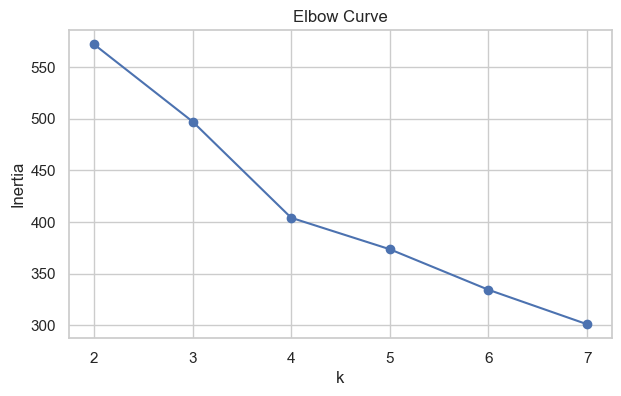

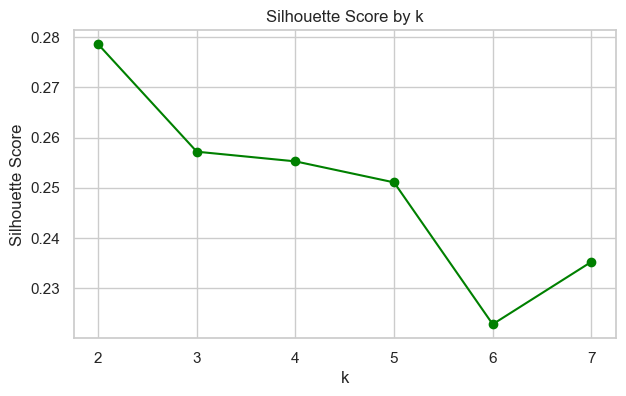

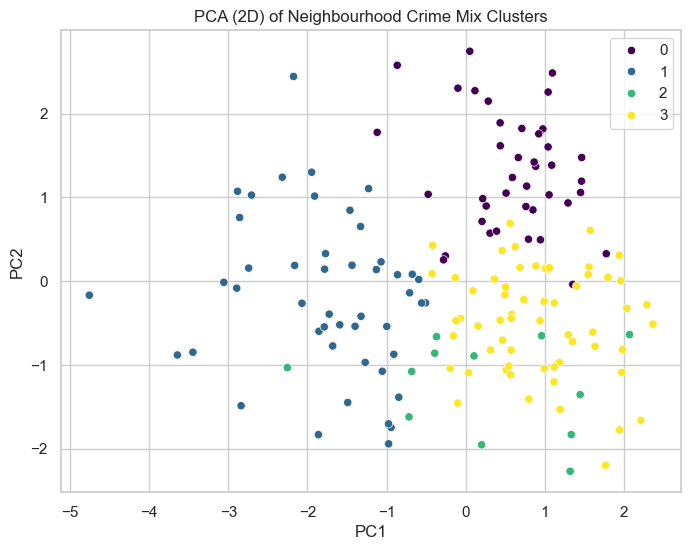

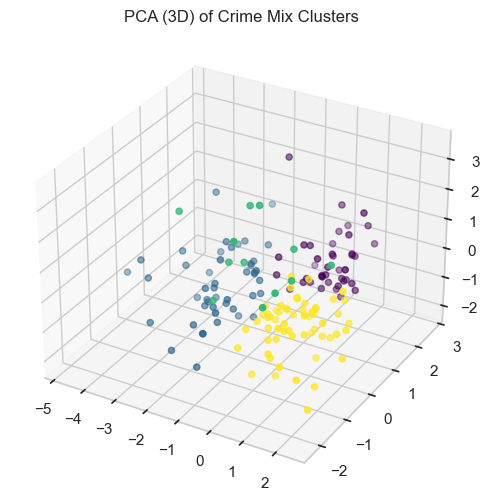

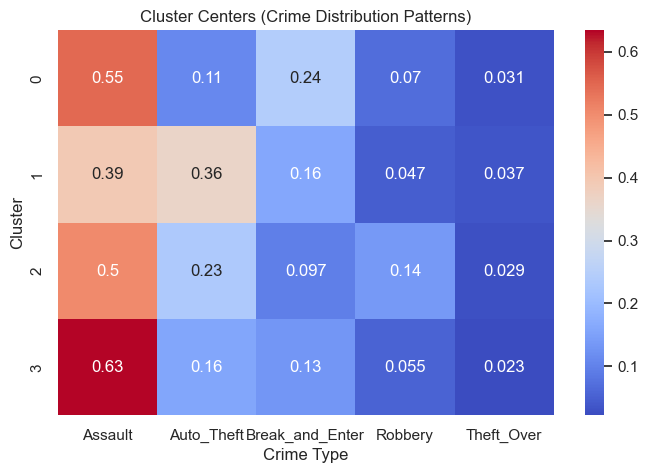

In [21]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


df = pd.read_csv("major-crime-indicators.csv")
df = df[df["OCC_YEAR"] == 2021]

df = df[["NEIGHBOURHOOD_158", "MCI_CATEGORY"]]

# crime count per neighbourhood per category
crime_pivot = df.groupby(["NEIGHBOURHOOD_158","MCI_CATEGORY"]).size().unstack(fill_value=0)


crime_pivot.columns = crime_pivot.columns.str.replace(" ", "_")

# crime mix
crime_props = crime_pivot.div(crime_pivot.sum(axis=1), axis=0)

# Scale (z-scores)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(crime_props)

# elbow + silhouette
K = range(2, 8)
inertia = []
sil_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

# Plot elbow
plt.figure(figsize=(7,4))
plt.plot(K, inertia, "-o")
plt.title("Elbow Curve")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

# Plot silhouette
plt.figure(figsize=(7,4))
plt.plot(K, sil_scores, "-o", color="green")
plt.title("Silhouette Score by k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()


best_k = 4 

kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

crime_props["Cluster"] = labels

# PCA 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=labels, palette="viridis")
plt.title("PCA (2D) of Neighbourhood Crime Mix Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# PCA 3D
pca3 = PCA(n_components=3)
pcs3 = pca3.fit_transform(X_scaled)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcs3[:,0], pcs3[:,1], pcs3[:,2], c=labels, cmap="viridis")
ax.set_title("PCA (3D) of Crime Mix Clusters")
plt.show()

# Heatmap of cluster centers (z-scores)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=crime_props.columns[:-1])

plt.figure(figsize=(8,5))
sns.heatmap(centers, annot=True, cmap="coolwarm")
plt.title("Cluster Centers (Crime Distribution Patterns)")
plt.xlabel("Crime Type")
plt.ylabel("Cluster")
plt.show()


CRIME INSIGHTS

PCA 
1. Clusters are well separated, meaning crime patterns differ meaningfully across neighbourhoods.
2. The purple cluster (0) is grouped tightly, homogeneous crime profile.
3. The yellow cluster (3) is stretched, more variation - mixed crime types.
4. The green & blue clusters show mid-range behaviours
 PCA scatterplots show that neighbourhoods group into distinct regions. PC1 separates neighbourhoods by overall crime intensity, and PC2 differentiates them by the specific mix of crime types.

Heatmap - raw numbers

Cluster 0 – High Assault Areas
Assault is the dominant crime type (0.55)
Break and Enter moderate (0.24)
Very low Auto Theft, Robbery, Theft Over
Interpersonal crime focused

Cluster 1 – Balanced Assault + Auto Theft
Assault moderately high (0.39)
Auto Theft also high (0.36)
Other crimes very low
Mixed crime neighbourhoods with both interpersonal and property crime. Violent + vehicle crime mixed areas

Cluster 2 – Moderate Assault + Mid Auto Theft + More Break & Enter
Assault ~0.50
Auto Theft ~0.23
Break & Enter ~0.09
Robbery is higher here than in other clusters (~0.14)
property-crime neighbourhoods

Cluster 3 – Very High Assault (0.63) + Some Auto Theft
Highest assault concentration of all clusters
Moderate Auto Theft
Everything else low
Hotspot for highest-risk violent crimes







Crime cluster silhouette (k=4): 0.25971513140389996


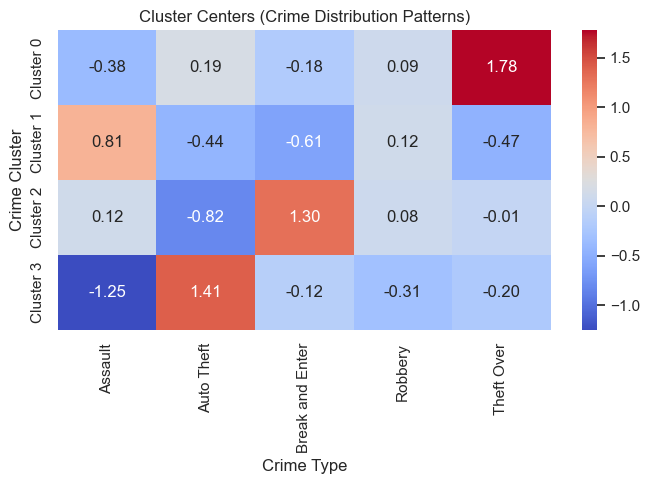

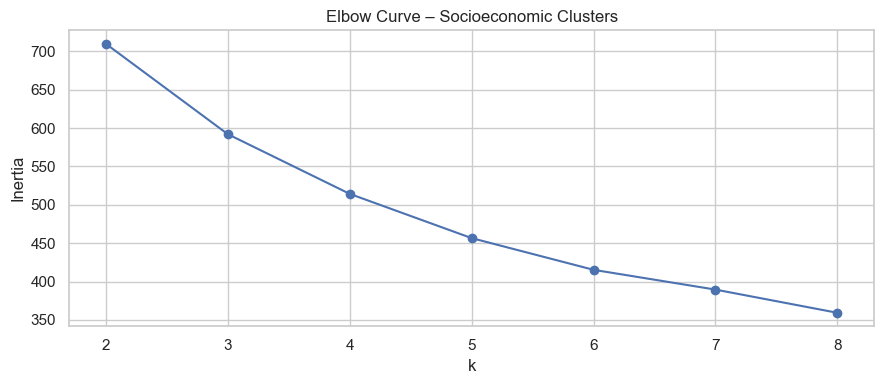

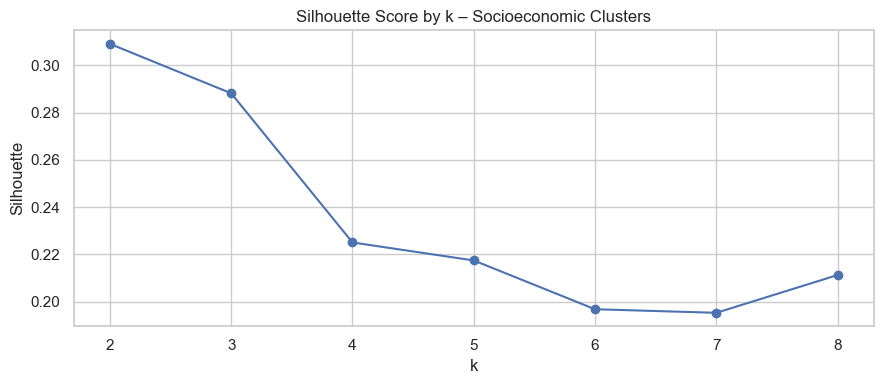

Socioeconomic cluster silhouette (k=4): 0.22502341950182828


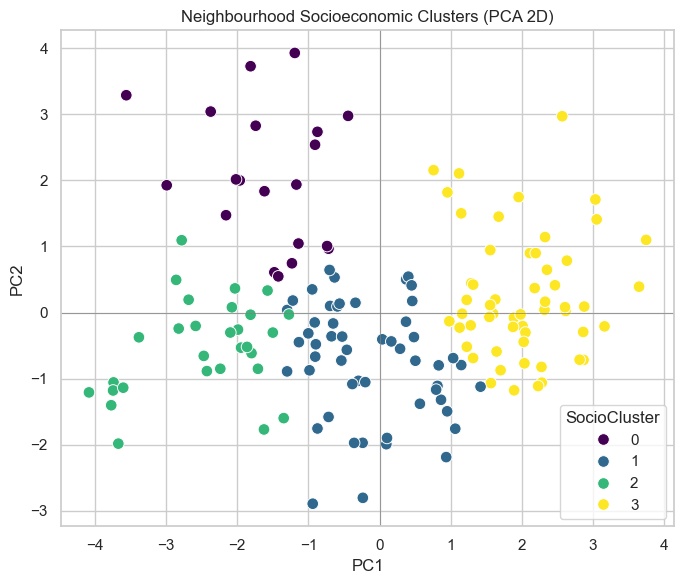

Explained variance (PC1, PC2): [0.48454483 0.22161948]


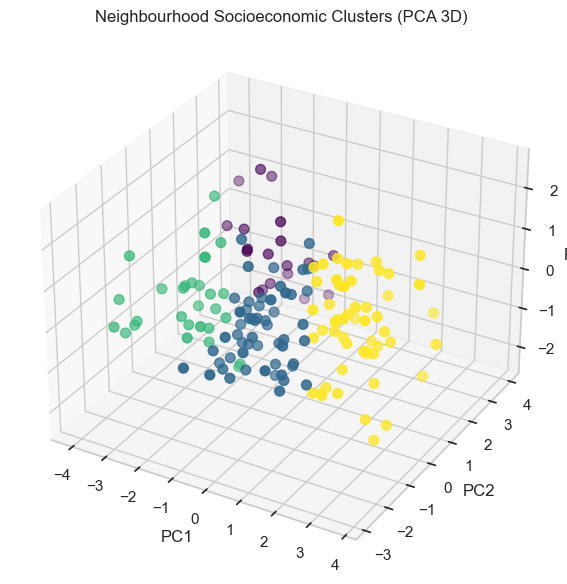

/var/folders/y0/7m6nkz493vd5rdb_rb4g62gw0000gn/T/ipykernel_11125/3927127398.py:229: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


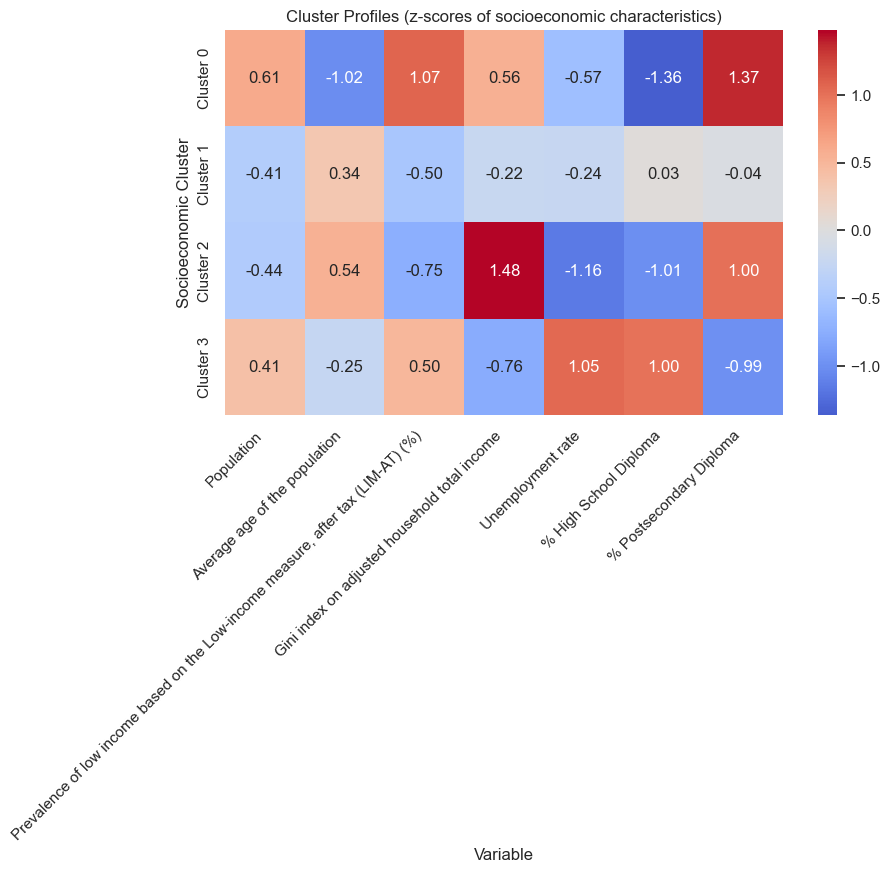

/var/folders/y0/7m6nkz493vd5rdb_rb4g62gw0000gn/T/ipykernel_11125/3927127398.py:252: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


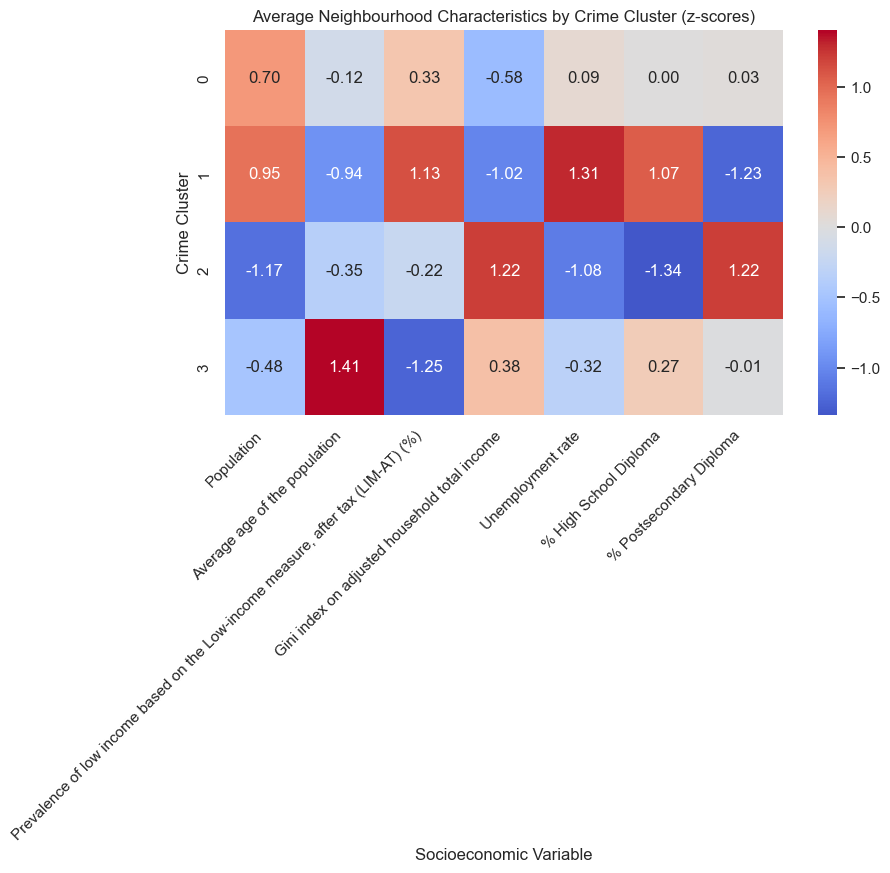

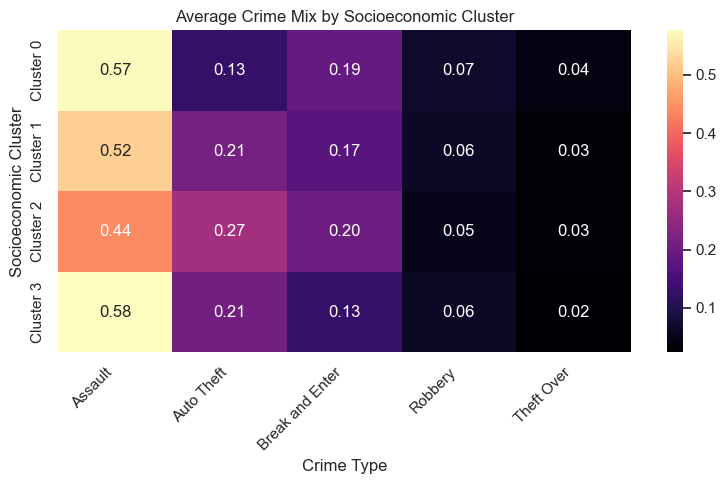

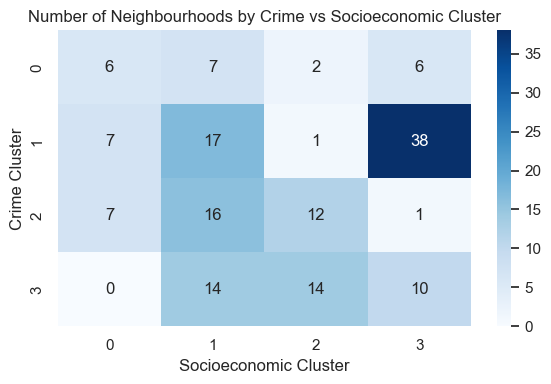

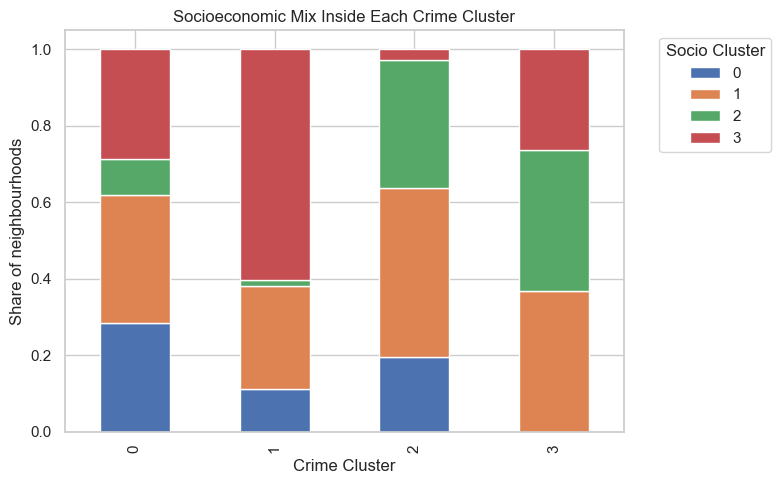

In [61]:

# mixed


import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")



# Crime file
if os.path.exists("major-crime-indicators (1).csv"):
    CRIME_FILE = "major-crime-indicators (1).csv"
else:
    CRIME_FILE = "major-crime-indicators.csv"

# Census file
if os.path.exists("158-model - Copy.xlsx"):
    CENSUS_FILE = "158-model - Copy.xlsx"
else:
    CENSUS_FILE = "158-model - Copy (1).xlsx"

crime = pd.read_csv(CRIME_FILE)
census_raw = pd.read_excel(CENSUS_FILE, sheet_name="hd2021_census_profile")


# 2. Crime mix per neighbourhood (2021 only) 

crime_2021 = crime[crime["REPORT_YEAR"] == 2021].copy()


crime_mix_counts = crime_2021.pivot_table(
    index="HOOD_158",
    columns="MCI_CATEGORY",
    values="EVENT_UNIQUE_ID",
    aggfunc="count",
    fill_value=0
)


crime_cols = ["Assault", "Auto Theft", "Break and Enter", "Robbery", "Theft Over"]
crime_mix_counts = crime_mix_counts[crime_cols]


crime_mix_counts = crime_mix_counts[crime_mix_counts.index != "NSA"]


crime_mix = crime_mix_counts.div(crime_mix_counts.sum(axis=1), axis=0)


crime_mix = crime_mix.reset_index()
crime_mix["HDNUM"] = crime_mix["HOOD_158"].astype(int)


socio_cols = [
    "Population",
    "Average age of the population",
    "Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",
    "Gini index on adjusted household total income",
    "Unemployment rate",
    "% High School Diploma",
    "% Postsecondary Diploma"
]

census_sel = census_raw[
    census_raw["Neighbourhood Number"].isin(socio_cols)
].set_index("Neighbourhood Number")

census_T = census_sel.T

census_features = census_T.reset_index().rename(columns={"index": "HDNUM"})
census_features["HDNUM"] = census_features["HDNUM"].astype(int)



combined = pd.merge(crime_mix, census_features, on="HDNUM", how="inner")



X_crime = combined[crime_cols].values
X_crime_scaled = StandardScaler().fit_transform(X_crime)

k_crime = 4
km_crime = KMeans(n_clusters=k_crime, random_state=42, n_init=10)
combined["CrimeCluster"] = km_crime.fit_predict(X_crime_scaled)

print("Crime cluster silhouette (k=4):",
      silhouette_score(X_crime_scaled, combined["CrimeCluster"]))

# Crime cluster centres 
crime_centres = pd.DataFrame(
    km_crime.cluster_centers_,
    columns=crime_cols
)

plt.figure(figsize=(7,5))
sns.heatmap(
    crime_centres,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    yticklabels=[f"Cluster {i}" for i in range(k_crime)]
)
plt.title("Cluster Centers (Crime Distribution Patterns)")
plt.xlabel("Crime Type")
plt.ylabel("Crime Cluster")
plt.tight_layout()
plt.show()


# 6. Socioeconomic clusters 


X_socio = combined[socio_cols].values
scaler_socio = StandardScaler()
X_socio_scaled = scaler_socio.fit_transform(X_socio)


K_range = range(2, 9)
inertia_socio = []
sil_socio = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_socio_scaled)
    inertia_socio.append(km.inertia_)
    sil_socio.append(silhouette_score(X_socio_scaled, labels))

plt.figure(figsize=(9,4))
plt.plot(K_range, inertia_socio, "o-")
plt.title("Elbow Curve – Socioeconomic Clusters")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(K_range)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.plot(K_range, sil_socio, "o-")
plt.title("Silhouette Score by k – Socioeconomic Clusters")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.xticks(K_range)
plt.tight_layout()
plt.show()


k_socio = 4
km_socio = KMeans(n_clusters=k_socio, random_state=42, n_init=10)
combined["SocioCluster"] = km_socio.fit_predict(X_socio_scaled)

print("Socioeconomic cluster silhouette (k=4):",
      silhouette_score(X_socio_scaled, combined["SocioCluster"]))

#PCA 2D 
pca2 = PCA(n_components=2, random_state=42)
pcs2 = pca2.fit_transform(X_socio_scaled)
combined["PC1"] = pcs2[:, 0]
combined["PC2"] = pcs2[:, 1]

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=combined,
    x="PC1", y="PC2",
    hue="SocioCluster",
    palette="viridis",
    s=70
)
plt.title("Neighbourhood Socioeconomic Clusters (PCA 2D)")
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.tight_layout()
plt.show()

print("Explained variance (PC1, PC2):", pca2.explained_variance_ratio_)

# PCA 3D
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

pca3 = PCA(n_components=3, random_state=42)
pcs3 = pca3.fit_transform(X_socio_scaled)
combined["PC3"] = pcs3[:, 2]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    combined["PC1"],
    combined["PC2"],
    combined["PC3"],
    c=combined["SocioCluster"],
    cmap="viridis",
    s=50
)
ax.set_title("Neighbourhood Socioeconomic Clusters (PCA 3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()

# Heatmap of socio cluster profiles (in z-score)

socio_centres = pd.DataFrame(
    km_socio.cluster_centers_,
    columns=socio_cols
)

plt.figure(figsize=(9,5))
sns.heatmap(
    socio_centres,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    yticklabels=[f"Cluster {i}" for i in range(k_socio)]
)
plt.title("Cluster Profiles (z-scores of socioeconomic characteristics)")
plt.xlabel("Variable")
plt.ylabel("Socioeconomic Cluster")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Joint visuals: CrimeCluster × SocioCluster


# a) Average neighbourhood characteristics by CrimeCluster
crime_socio_means = combined.groupby("CrimeCluster")[socio_cols].mean()
crime_socio_means_z = (crime_socio_means - crime_socio_means.mean()) / crime_socio_means.std()

plt.figure(figsize=(9,5))
sns.heatmap(
    crime_socio_means_z,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Average Neighbourhood Characteristics by Crime Cluster (z-scores)")
plt.ylabel("Crime Cluster")
plt.xlabel("Socioeconomic Variable")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# b) Average crime mix by SocioCluster
socio_crime_means = combined.groupby("SocioCluster")[crime_cols].mean()

plt.figure(figsize=(8,5))
sns.heatmap(
    socio_crime_means,
    annot=True,
    fmt=".2f",
    cmap="magma",
    yticklabels=[f"Cluster {i}" for i in range(k_socio)]
)
plt.title("Average Crime Mix by Socioeconomic Cluster")
plt.ylabel("Socioeconomic Cluster")
plt.xlabel("Crime Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# c) Cross-tab of CrimeCluster × SocioCluster
cross = pd.crosstab(combined["CrimeCluster"], combined["SocioCluster"])

plt.figure(figsize=(6,4))
sns.heatmap(cross, annot=True, fmt="d", cmap="Blues")
plt.title("Number of Neighbourhoods by Crime vs Socioeconomic Cluster")
plt.xlabel("Socioeconomic Cluster")
plt.ylabel("Crime Cluster")
plt.tight_layout()
plt.show()

# d) Stacked bar: socioeconomic composition inside each crime cluster
cross_prop = cross.div(cross.sum(axis=1), axis=0)

plt.figure(figsize=(8,5))
cross_prop.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Socioeconomic Mix Inside Each Crime Cluster")
plt.ylabel("Share of neighbourhoods")
plt.xlabel("Crime Cluster")
plt.legend(title="Socio Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


1. Crime Cluster Profiles 
Cluster 0 – High Theft-Over Cluster: Likely commercial or higher-income zones where property value is high.
Cluster 1 – High Assault & Robbery Cluster: Suggests densely populated, socially active areas with more interpersonal conflict.
Cluster 2 – High Auto Theft & Break and Enter Cluster: Indicates older residential neighbourhoods with more standalone homes.
Cluster 3 – Auto-Theft Concentration Likely suburban neighbourhoods, with more driveways/vehicles and lower foot traffic.


2. Socioeconomic Cluster Profiles
Cluster 0 – Young, High-Income Neighbourhoods: epresents downtown core / professional young-adult neighbourhoods.
Cluster 1 – Older, Mid-Income Communities: Stable, mixed residential zones.
Cluster 2 - Income-Inequality & Unemployment Cluster: Represents vulnerable neighbourhoods with socioeconomic stress.
Cluster 3 – High-Education, Higher-Age Neighbourhoods: Likely established, affluent, older communities with strong educational profiles.



3. How Crime Patterns Relate to Socioeconomic Groups “Average Crime Mix by Socioeconomic Cluster” heatmap

- Assault is highest where income inequality & unemployment are highest (Socio Cluster 2).
Socio Cluster 2 shows lowest education + highest inequality + high unemployment
- Auto-Theft is highest in Socio Cluster 2 and Cluster 3.
Cluster 3: educated, older, stable neighbourhoods = more vehicles = more auto theft opportunities.
Cluster 2: vulnerable neighbourhoods =  opportunity + lower surveillance.
- Break-and-Enter aligns most with Socio Cluster 2.
areas with higher inequality and less social cohesion often see more break and enter

4. Socioeconomic Mix Inside Each Crime Cluster (stacked bar chart)

- Crime Cluster 0 (Theft-Over)
Mostly high-income, high-education areas (Socio 0 & 3).Theft Over tends to occur where property value is higher.

- Crime Cluster 1 (Assault)
Dominated by Socio Cluster 2 (vulnerability cluster). Strong socioeconomic link between poverty/inequality and assault.

- Crime Cluster 2 (Break-and-Enter)
Mostly Socio Cluster 2 & 3. Mix of vulnerable areas (low social cohesion) and older high-value residential areas.

- Crime Cluster 3 (Auto-Theft) Split between Socio Cluster 1 and 3. Suburban areas with higher car ownership attract auto theft.


Overall:
A. Crime patterns differ meaningfully across neighbourhoods.
Each cluster corresponds to a distinct type of crime hotspot (Assault, Theft-Over, B&E, Auto-Theft).

B. Socioeconomics strongly predict crime type distribution.
Inequality & unemployment = more Assault & Break-and-Enter
Education & older residents = more Auto-Theft
High-income & young professionals = more Theft-Over (property crime)

C. Policy Implications
Cluster-specific prevention will outperform uniform policing.
Assault reduction : invest in social services + community programs in Cluster 2 areas.
Auto-theft: target suburban neighbourhoods, improve security.
Break-and-enter: focus on neighbourhood watch.
Theft-over: increase commercial area surveillance & anti-shoplifting.
